# Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
# https://arxiv.org/pdf/1511.06434

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Epoch 1/20 | Loss D: 0.3665, Loss G: 4.1319


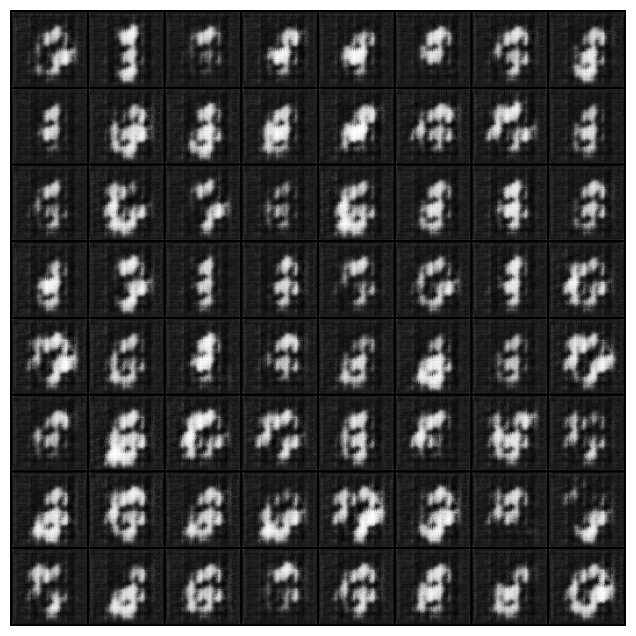

Epoch 2/20 | Loss D: 0.4314, Loss G: 1.1808
Epoch 3/20 | Loss D: 0.3682, Loss G: 1.0176
Epoch 4/20 | Loss D: 0.2043, Loss G: 2.1109
Epoch 5/20 | Loss D: 0.3893, Loss G: 2.2169


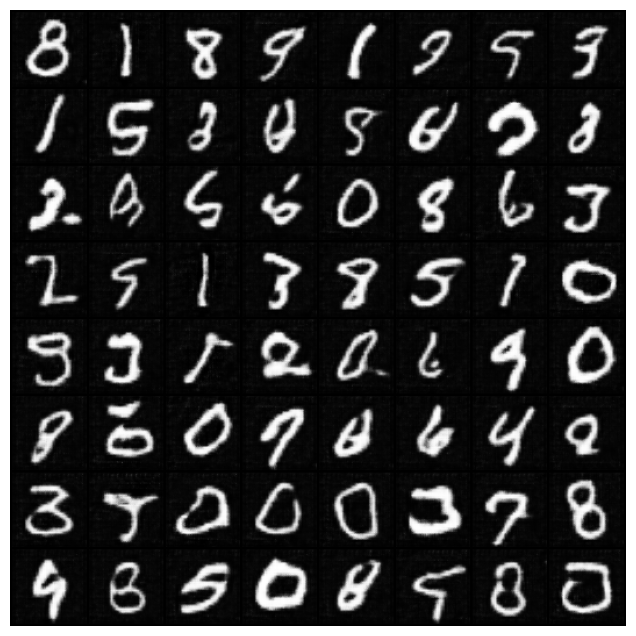

Epoch 6/20 | Loss D: 0.2731, Loss G: 1.0093
Epoch 7/20 | Loss D: 0.3361, Loss G: 2.7032
Epoch 8/20 | Loss D: 0.4170, Loss G: 4.1799
Epoch 9/20 | Loss D: 0.3502, Loss G: 0.7108
Epoch 10/20 | Loss D: 0.1297, Loss G: 3.0795


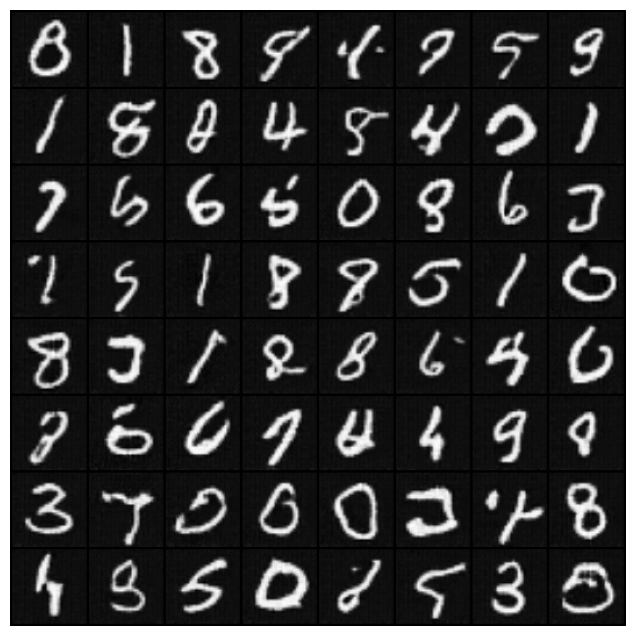

Epoch 11/20 | Loss D: 0.2802, Loss G: 2.8438
Epoch 12/20 | Loss D: 0.5170, Loss G: 5.7773
Epoch 13/20 | Loss D: 0.1520, Loss G: 4.4004
Epoch 14/20 | Loss D: 0.2017, Loss G: 2.6312
Epoch 15/20 | Loss D: 0.0967, Loss G: 5.0627


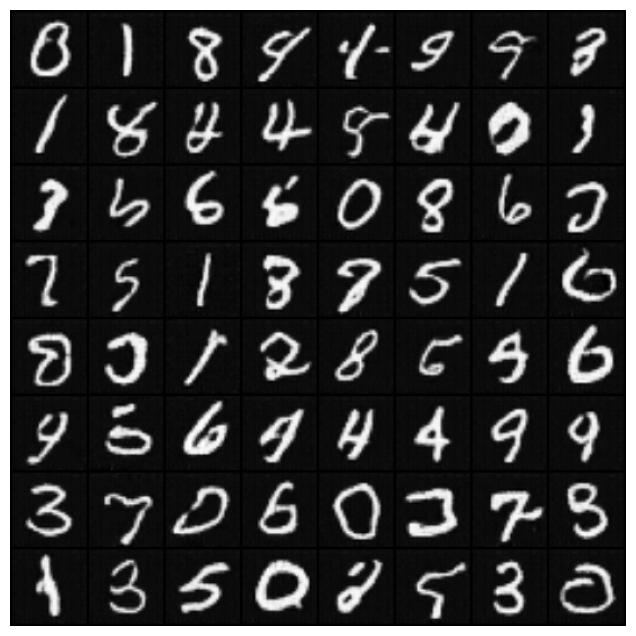

Epoch 16/20 | Loss D: 0.2278, Loss G: 3.5368
Epoch 17/20 | Loss D: 0.2848, Loss G: 2.0029
Epoch 18/20 | Loss D: 0.2847, Loss G: 1.8461
Epoch 19/20 | Loss D: 0.2218, Loss G: 2.2930
Epoch 20/20 | Loss D: 0.0361, Loss G: 3.7290


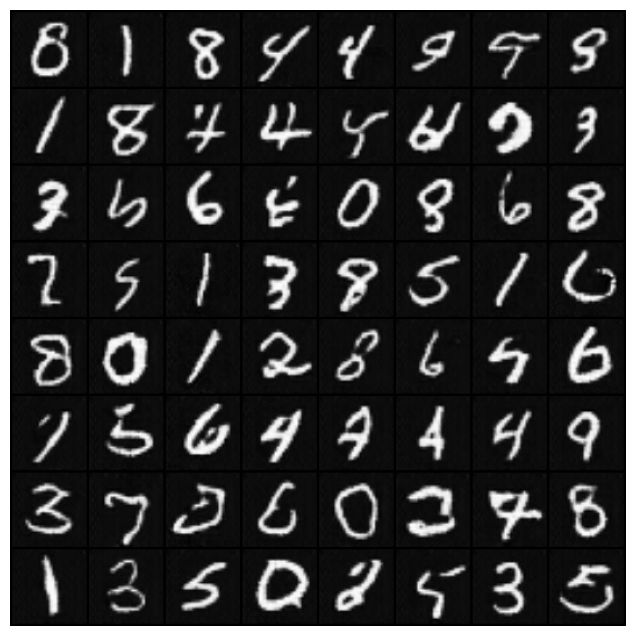

In [1]:
# ===== 0) Imports =====
import torch, torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# ===== 1) Hyperparams =====
z_dim = 100
img_size = 64   # DCGAN paper trained 64x64
channels = 1    # MNIST = 1, CIFAR/LSUN = 3
batch_size = 128
lr = 0.0002
betas = (0.5, 0.999)
epochs = 20

# ===== 2) Data =====
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1,1]
])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===== 3) Weight Init =====
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, "bias") and m.bias is not None:
        nn.init.constant_(m.bias.data, 0)

# ===== 4) Generator =====
class Generator(nn.Module):
    def __init__(self, z_dim, channels):
        super().__init__()
        self.net = nn.Sequential(
            # input Z latent → 512 feature maps of 4x4
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()  # output in [-1,1]
        )
    def forward(self, z):
        return self.net(z)

# ===== 5) Discriminator =====
class Discriminator(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1, 1)

# ===== 6) Instantiate =====
G = Generator(z_dim, channels).to(device)
D = Discriminator(channels).to(device)
G.apply(weights_init); D.apply(weights_init)

criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
opt_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# ===== 7) Training Loop =====
for epoch in range(epochs):
    for i, (real, _) in enumerate(loader):
        real = real.to(device)
        b = real.size(0)
        noise = torch.randn(b, z_dim, 1, 1, device=device)
        fake = G(noise)

        # --- Train D ---
        opt_D.zero_grad()
        lossD_real = criterion(D(real), torch.ones(b,1, device=device))
        lossD_fake = criterion(D(fake.detach()), torch.zeros(b,1, device=device))
        lossD = (lossD_real + lossD_fake) * 0.5
        lossD.backward()
        opt_D.step()

        # --- Train G ---
        opt_G.zero_grad()
        lossG = criterion(D(fake), torch.ones(b,1, device=device))
        lossG.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    # visualize
    if (epoch+1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        grid = make_grid(fake, nrow=8, normalize=True)
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(grid,(1,2,0)))
        plt.axis("off"); plt.show()


# 🔎 Visual Progress Across Epochs

## Epochs 1–5
- Samples are blurry blobs, but digit-like structures (e.g., “1”, “9”) emerge very early.  
- **Loss D** ~0.36–0.43, **Loss G** ~1.1–2.2 → Both networks are learning; balance looks good.

## Epochs 6–10
- Digits become much clearer; you see recognizable “0, 3, 5, 8” etc.  
- Diversity across digits is present.  
- **Loss D** ~0.27–0.39, **Loss G** fluctuating 1.0–3.7 → healthy adversarial dynamics.

## Epochs 11–15
- Samples are sharper, closer to MNIST digits, very crisp outlines.  
- Still good diversity (“8, 1, 4, 6, 0, 7…”).  
- **Loss D** drops (as low as 0.09), **Loss G** spikes (5.0).  
  - Suggests D is temporarily overpowering, but G still produces decent outputs.

## Epochs 16–20
- Final samples are very clean MNIST digits, comparable to the figures in the DCGAN paper.  
- Some digits are near perfect; minor artifacts appear, but overall quality is **high**.  
- Diversity preserved across digits → no severe mode collapse.

---

# ✅ Strengths of Your DCGAN Results
- **Stability:** Training remained stable throughout 20 epochs; no collapse like in vanilla GAN.  
- **Clarity:** By epoch 10+, digits are crisp and readable.  
- **Diversity:** All digits (0–9) appear across samples, avoiding collapse.  
- **Faithfulness:** Matches Radford et al.’s findings — convolutional architecture + batchnorm stabilizes learning.  


# 🆚 GAN vs. DCGAN

| Aspect | GAN (Goodfellow et al., 2014) | DCGAN (Radford et al., 2015) | Why it matters |
|---|---|---|---|
| **Architecture** | Fully-connected MLPs for G and D | Deep ConvNets (ConvTranspose in G, Conv in D) | Convs exploit spatial locality → better image quality |
| **Layers** | Generator: ReLU hidden + Tanh output; Discriminator: LeakyReLU + Sigmoid | Generator: ReLU + BatchNorm + Tanh; Discriminator: LeakyReLU + BatchNorm (no FC) | BatchNorm + convs stabilize gradients and avoid collapse |
| **Pooling** | Implicit via fully connected layers | Strided conv (D) and fractionally-strided conv (G) | Preserves spatial structure vs. flattening |
| **Initialization** | Default/random | Normal(0,0.02) for weights | More stable convergence |
| **Training Stability** | Very unstable, prone to mode collapse | Much more stable, less collapse | DCGAN became baseline for generative modeling |
| **Input size** | Works on flattened images (e.g., 28×28 = 784-dim vector) | Scales to higher resolutions (e.g., 64×64, 128×128) | Enables realistic image generation |
| **Output quality** | Blurry, often collapsed to one digit | Clearer, sharper, more diverse samples | Demonstrates value of convs in generative modeling |
| **Latent space** | Interpolation possible, but not smooth | Smooth latent interpolation, semantic arithmetic (e.g., “smiling face – neutral + glasses”) | Enables controllable generation |
| **Dataset scaling** | Small datasets (MNIST) | Larger datasets (CelebA, LSUN, ImageNet subsets) | First GAN variant to work well on natural images |
